# Mace et al. analysis

This notebook contains the computational analyses and figure generation code related to the Mace et al. 2020 dataset. Execute all cells sequentially to reproduce the results and generate the accompanying figures. To reproduce figures S1b and S1c, change the method variable to 'PCA'.



In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skdim.id import MLE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import Isomap
from scipy.spatial.distance import pdist, squareform
from itertools import combinations
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.cm as cm
plt.rcParams.update({'font.size': 9})
plt.rcParams['svg.fonttype'] = 'none'


In [23]:
def isomap_dim(matrix,n_components = 8):
    isomap = Isomap(n_components=n_components, 
                    n_neighbors=8,  # Tune this parameter
                    metric='euclidean')
    isomap.fit(matrix)
    eigenvalues = isomap.eigenvalues_
    explained_ratios = eigenvalues / np.sum(eigenvalues)
    return eff_rank(explained_ratios)

In [24]:
def add_avg_euclidean_distance(df):
    coords = df.iloc[:2].values.astype(float)
    conditions = df.iloc[-1].values
    
    avg_dists = []
    for i in range(len(df.columns)):
        same_condition = conditions == conditions[i]
        same_condition[i] = False  # exclude self
        
        if same_condition.any():
            point = coords[:, i]
            other_points = coords[:, same_condition]
            dists = np.sqrt(((point[:, None] - other_points)**2).sum(axis=0))
            avg_dists.append(dists.mean())
        else:
            avg_dists.append(np.nan)
    
    return pd.concat([df, pd.DataFrame([avg_dists], index=['avg_euclidean_dist'], columns=df.columns)])

In [25]:
def average_pairwise_euclidean_distance(df):
    """
    Compute the average pairwise Euclidean distance between all columns of a DataFrame.
    
    Each column is treated as a vector, and the Euclidean distance is computed
    between every pair of columns.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame where each column represents a vector
    
    Returns:
    --------
    float
        The average pairwise Euclidean distance between all columns
    
    Example:
    --------
    >>> import pandas as pd
    >>> import numpy as np
    >>> 
    >>> # Create sample data
    >>> data = {
    ...     'A': [1, 2, 3],
    ...     'B': [4, 5, 6],
    ...     'C': [7, 8, 9]
    ... }
    >>> df = pd.DataFrame(data)
    >>> 
    >>> result = average_pairwise_euclidean_distance(df)
    >>> print(f"Average pairwise distance: {result:.4f}")
    """
    # Check if DataFrame is empty or has only one column
    if df.empty:
        raise ValueError("DataFrame is empty")
    
    if df.shape[1] < 2:
        raise ValueError("DataFrame must have at least 2 columns")
    
    # Convert DataFrame to numpy array and transpose 
    # so each row represents a column (vector)
    vectors = df.values.T
    # Method 1: Using scipy.spatial.distance.pdist (most efficient)
    # pdist computes pairwise distances between rows, so we transpose
    distances = pdist(vectors, metric='euclidean')
    
    # Return the mean of all pairwise distances
    return np.mean(distances)

In [26]:
def eff_rank(array):
    return np.sum(-array*np.log(array))

In [27]:
def tsne_projection(df, perplexity=30, n_iter=1000, random_state=40):
    """
    Apply t-SNE to reduce dimensionality of samples from n features to 2D.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe with shape (n_features, m_samples) where:
        - Rows represent features/datapoints
        - Columns represent samples
    perplexity : float, default=30
        The perplexity parameter for t-SNE. Consider values between 5 and 50.
    n_iter : int, default=1000
        Maximum number of iterations for optimization.
    random_state : int, default=42
        Random state for reproducibility.
    
    Returns:
    --------
    pandas.DataFrame
        Output dataframe with shape (2, m_samples) where:
        - Rows represent the 2 t-SNE dimensions
        - Columns represent the same samples as input
        - Index labels are 'tsne_1' and 'tsne_2'
    """
    # Transpose the dataframe so that samples become rows and features become columns
    # This is required because t-SNE expects samples as rows
    df_transposed = df.T
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=random_state)
    tsne_result = tsne.fit_transform(df_transposed)
    
    # Create output dataframe with the same column names but with 2 rows
    output_df = pd.DataFrame(
        tsne_result.T,  # Transpose to get (2, m_samples) shape
        columns=df.columns,  # Keep the same sample names
        index=['tsne_1', 'tsne_2']  # Label the two dimensions
    )
    
    return output_df

In [28]:
def ev_func(matrix):
    # Standardize the data (recommended for PCA)
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(matrix)
    # Create a PCA instance
    pca = PCA()
    # Fit the data and transform it to the principal components
    principal_components = pca.fit_transform(matrix)
    # Access the explained variance ratio to understand the importance of each principal component
    explained_variance_ratio = pca.explained_variance_ratio_
    # Plot the cumulative explained variance
    cumulative_explained_variance = explained_variance_ratio.cumsum()
    return explained_variance_ratio


In [29]:
def pca_projection_3d(dataframe, standardize=True,dim = 3):
    """
    Perform PCA on an m×n dataframe and return projection onto first 3 components.
    
    Parameters:
    -----------
    dataframe : pd.DataFrame
        Input dataframe of shape (m, n) where:
        - m rows (datapoints/features)
        - n columns (samples)
    standardize : bool, default=True
        Whether to standardize features before PCA
    
    Returns:
    --------
    pd.DataFrame
        Shape (3, n) with first 3 principal components as rows
    """
    # Get the data as numpy array and transpose it
    # PCA expects samples as rows, features as columns
    data = dataframe.T.values  # Shape: (n, m)
    
    # Optional standardization (recommended for PCA)
    if standardize:
        scaler = StandardScaler()
        data = scaler.fit_transform(data)
    
    # Perform PCA
    pca = PCA(n_components=dim)
    projected_data = pca.fit_transform(data)  # Shape: (n, 3)
    
    # Transpose back to get (3, n) and create dataframe
    result_df = pd.DataFrame(
        projected_data.T,  # Transpose to (3, n)
        columns=dataframe.columns,  # Use original column names as samples
        index=[f'PC{i+1}' for i in range(dim)]  # Name rows as PC1, PC2, PC3
    )
    
    # Print explained variance for reference
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Total variance explained: {np.sum(pca.explained_variance_ratio_):.3f}")
    
    return result_df

In [30]:
csv_file_path = 'data/GSE115556_sample_meta.csv'
df = pd.read_csv(csv_file_path)

df.head(10)

,Unnamed: 0,Sample_Name,Well_Code,Plate_Code,Experiment,Media,Stress,Drug,Strain_Code,Strain,...,Prep...AO.Input,Prep...PCR.Cycles,Prep.QC,NumberOfPeaks,X.RiP,tophat_path,star_path,star_column,kallisto_path,Condition
0,1,17d,17,d,None_SDC_Cocktail_RIM15,SDC,None,Cocktail,RIM15,RIM15,...,1,15,PASSED,1457,56.184,../../intermediate/counts/tophat/17d_gene_coun...,../../intermediate/counts/star/17d_sequence.tx...,3,../../intermediate/kallisto/kallisto_output/17...,SDC
1,2,19d,19,d,None_SDC_Cocktail_SLT2,SDC,None,Cocktail,SLT2,SLT2,...,1,15,PASSED,1576,59.276,../../intermediate/counts/tophat/19d_gene_coun...,../../intermediate/counts/star/19d_sequence.tx...,3,../../intermediate/kallisto/kallisto_output/19...,SDC
2,3,20d,20,d,None_SDC_Cocktail_SNF1,SDC,None,Cocktail,SNF1,SNF1,...,1,15,PASSED,1576,58.104,../../intermediate/counts/tophat/20d_gene_coun...,../../intermediate/counts/star/20d_sequence.tx...,3,../../intermediate/kallisto/kallisto_output/20...,SDC
3,4,21d,21,d,None_SDC_Cocktail_SSN3,SDC,None,Cocktail,SSN3,SSN3,...,1,15,PASSED,1449,57.419,../../intermediate/counts/tophat/21d_gene_coun...,../../intermediate/counts/star/21d_sequence.tx...,3,../../intermediate/kallisto/kallisto_output/21...,SDC
4,5,22d,22,d,None_SDC_Cocktail_STE11,SDC,None,Cocktail,STE11,STE11,...,1,15,PASSED,1665,62.228,../../intermediate/counts/tophat/22d_gene_coun...,../../intermediate/counts/star/22d_sequence.tx...,3,../../intermediate/kallisto/kallisto_output/22...,SDC
5,6,23d,23,d,None_SDC_Cocktail_TOR2,SDC,None,Cocktail,TOR2,TOR2,...,1,15,PASSED,1521,54.926,../../intermediate/counts/tophat/23d_gene_coun...,../../intermediate/counts/star/23d_sequence.tx...,3,../../intermediate/kallisto/kallisto_output/23...,SDC
6,7,25d,25,d,None_SDC_Cocktail_WT1,SDC,None,Cocktail,WT1,WT,...,1,15,PASSED,1760,58.955,../../intermediate/counts/tophat/25d_gene_coun...,../../intermediate/counts/star/25d_sequence.tx...,3,../../intermediate/kallisto/kallisto_output/25...,SDC
7,8,26d,26,d,None_SDC_Cocktail_WT2,SDC,None,Cocktail,WT2,WT,...,1,15,PASSED,1788,61.204,../../intermediate/counts/tophat/26d_gene_coun...,../../intermediate/counts/star/26d_sequence.tx...,3,../../intermediate/kallisto/kallisto_output/26...,SDC
8,9,30d,30,d,None_SDC_Cocktail_YGK3,SDC,None,Cocktail,YGK3,YGK3,...,1,15,PASSED,1779,65.038,../../intermediate/counts/tophat/30d_gene_coun...,../../intermediate/counts/star/30d_sequence.tx...,3,../../intermediate/kallisto/kallisto_output/30...,SDC
9,10,32d,32,d,None_SDC_Cocktail_YPK3,SDC,None,Cocktail,YPK3,YPK3,...,1,15,PASSED,1793,63.251,../../intermediate/counts/tophat/32d_gene_coun...,../../intermediate/counts/star/32d_sequence.tx...,3,../../intermediate/kallisto/kallisto_output/32...,SDC


In [31]:
np.unique(df['Condition'])

array(['Azetidine', 'Fluconazole', 'Glucose Depletion', 'Heatshock',
       'Menadione', 'Rapamycin', 'SDC', 'Salt', 'Tunicamycin', 'YPD'],
      dtype=object)

In [32]:
strain_masks = {}
cond_masks = {}

In [33]:
for code in np.unique(df['Strain_Code']):
    strain_masks[code] = np.array(df['Sample_Name'][df['Strain_Code'] == code])
for code in np.unique(df['Condition']):
    cond_masks[code] = np.array(df['Sample_Name'][df['Condition'] == code])

In [34]:
strain_list = list(strain_masks.keys())

In [35]:
cond_masks

{'Azetidine': array(['1a', '2a', '3a', '4a', '5a', '6a', '7a', '8a', '9a', '10a', '11a',
        '12a', '13a', '14a', '15a', '16a', '17a', '18a', '19a', '20a',
        '21a', '22a', '23a', '24a', '25a', '26a', '27a', '29a', '30a',
        '31a', '32a'], dtype=object),
 'Fluconazole': array(['17f', '18f', '19f', '20f', '21f', '22f', '23f', '24f', '25f',
        '26f', '27f', '28f', '29f', '30f', '31f', '32f', '1f', '2f', '3f',
        '4f', '5f', '6f', '7f', '8f', '9f', '10f', '11f', '12f', '13f',
        '14f', '15f', '16f'], dtype=object),
 'Glucose Depletion': array(['1g', '2g', '3g', '4g', '5g', '6g', '7g', '8g', '9g', '10g', '11g',
        '13g', '15g', '16g', '17g', '19g', '20g', '22g', '23g', '25g',
        '26g', '27g', '28g', '29g', '30g', '31g', '32g'], dtype=object),
 'Heatshock': array(['1h', '2h', '3h', '4h', '5h', '6h', '7h', '8h', '9h', '10h', '11h',
        '12h', '13h', '14h', '15h', '16h', '17h', '18h', '19h', '20h',
        '22h', '23h', '24h', '25h', '26h', '27h', '2

In [36]:
tpk_mask = df['Strain_Code'] == 'TPK123'
wt_mask = df['Strain_Code'] == 'WT1'
tpk_samples = df['Sample_Name'][tpk_mask]
tpk_stress = df['Stress'][tpk_mask]
tpk_drug = df['Drug'][tpk_mask]
wt_samples = df['Sample_Name'][wt_mask]
wt_stress = df['Stress'][wt_mask]
wt_drug = df['Drug'][wt_mask]

In [37]:

csv_file_path = 'data/GSE115556_normalized_counts_matrix.csv'
df = pd.read_csv(csv_file_path)

df.head(15)

,Unnamed: 0,17d,19d,20d,21d,22d,23d,25d,26d,30d,...,24s,25s,26s,27s,29s,30s,32s,8r,9r,15t
0,CYS3,1393.380209,1609.935334,2291.568992,2267.927011,2664.143282,6409.972475,1740.516933,2010.579252,3590.962074,...,3810.804974,979.220318,1078.071406,1064.685300,1857.313054,2131.909535,2356.336201,912.009589,903.307042,2488.134183
1,YAL069W,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,YAL068W-A,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.626349,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,PAU8,0.000000,0.997482,1.717174,0.000000,3.867804,1.927811,1.671966,1.879046,0.872864,...,1.827943,4.327611,2.729295,3.686158,0.909111,4.404772,4.217786,1.769747,6.149594,0.000000
4,YAL067W-A,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,SEO1,12.440895,21.944596,9.444458,20.094400,24.753945,60.726055,19.227613,18.164112,14.838686,...,11.881632,14.163090,11.826944,12.901553,18.182213,19.087344,16.168178,25.366373,36.897565,22.995695
6,YAL066W,0.000000,0.000000,0.000000,0.913382,1.547122,1.927811,0.000000,0.000000,0.000000,...,0.000000,0.393419,0.000000,1.228719,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,YAL065C,1.382322,1.994963,0.858587,0.913382,2.320682,1.927811,0.000000,0.000000,4.364319,...,2.284929,3.934192,1.819530,0.614360,1.818221,0.000000,1.405929,2.359663,1.366576,4.599139
8,YAL064W-B,5.529287,2.992445,4.292936,1.826764,0.000000,4.819528,3.343933,3.131743,0.872864,...,2.741915,3.147353,2.729295,2.457439,1.818221,1.468257,1.405929,1.769747,2.049865,1.839656
9,TDA8,0.000000,2.992445,0.858587,0.000000,1.547122,6.747339,2.507949,2.505395,1.745728,...,2.741915,1.180258,1.819530,1.228719,1.818221,2.936515,1.405929,4.719325,4.783018,1.839656


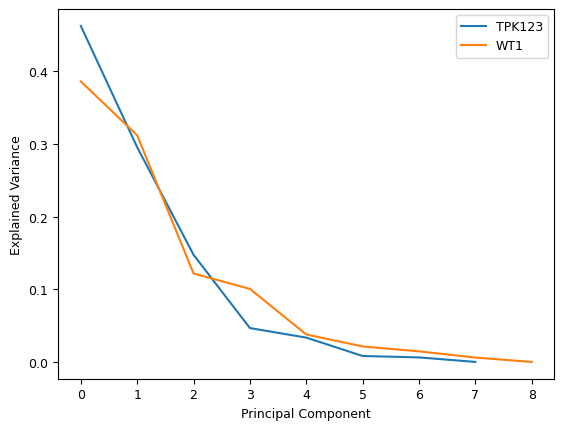

In [40]:
for i in range(len(strain_list)):
    ev_arr = ev_func(np.transpose(np.array(df[strain_masks[strain_list[i]]])))
    if strain_list[i] in ['WT1','TPK123']:
        plt.plot(ev_arr,label = strain_list[i])
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.savefig('figures/figS1a.svg', format='svg', bbox_inches='tight')
plt.legend()

In [41]:
wt_matrix = np.array(df[wt_samples])
wt_matrix_norm = wt_matrix/np.sum(wt_matrix,axis = 0)
tpk_matrix = np.array(df[tpk_samples])
tpk_matrix_norm = tpk_matrix/np.sum(tpk_matrix,axis = 0)


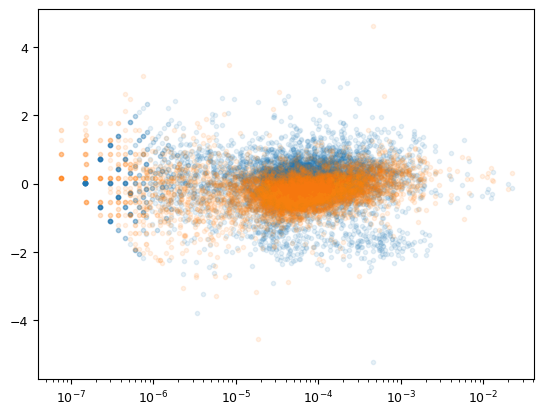

In [42]:
plt.scatter((wt_matrix_norm[:,0] + wt_matrix_norm[:,1])/2,np.log(wt_matrix_norm[:,0]/wt_matrix_norm[:,1]),marker='.',alpha = 0.1)
plt.scatter((wt_matrix_norm[:,1] + wt_matrix_norm[:,0])/2,np.log(wt_matrix_norm[:,6]/wt_matrix_norm[:,0]),marker='.',alpha = 0.1)
plt.xscale('log')


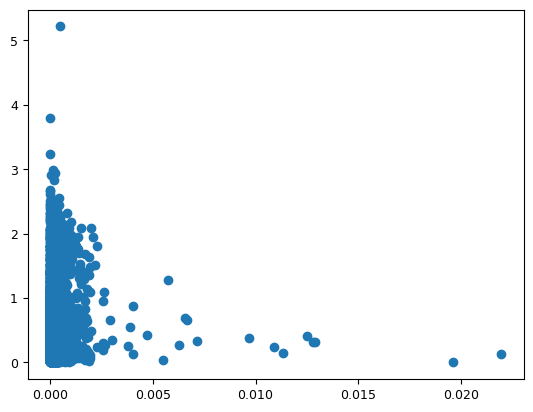

In [43]:
wt_means = (wt_matrix_norm[:,0] + wt_matrix_norm[:,1])/2
wt_lfc = np.abs(np.log(wt_matrix_norm[:,0]/wt_matrix_norm[:,1]))
plt.scatter(wt_means,wt_lfc)

In [73]:
#set tsne or PCA here
method = 'tsne'
if method == 'tsne':
    dist_df = tsne_projection(df.iloc[:, 1:])
elif method == 'pca':
    dist_df = pca_projection_3d(df.iloc[:, 1:],dim = 3)

In [74]:
dist_df

,17d,19d,20d,21d,22d,23d,25d,26d,30d,32d,...,24s,25s,26s,27s,29s,30s,32s,8r,9r,15t
tsne_1,-5.718367,6.640050,8.614289,10.677682,10.028372,-1.940500,6.351449,7.887018,10.847575,10.394019,...,0.372804,-2.831480,-2.693733,-2.633489,-0.892465,-0.417154,-0.543156,-16.755774,-16.568991,7.153104
tsne_2,-2.376414,-4.648109,-4.325012,-5.367931,-4.725493,4.449769,-4.615048,-4.649174,-4.710688,-3.936577,...,11.812280,8.603241,8.637337,8.531125,9.717621,9.146310,10.311067,0.629806,1.396316,4.991624


In [75]:
np.transpose(np.array(df[strain_masks['TPK123']])).shape

(8, 6692)

In [76]:
array = ev_func(np.transpose(np.array(df[strain_masks['TPK123']])))

In [77]:
eff_rank_list = []

In [78]:
for strain in strain_list:
    eff_rank_list.append(eff_rank(ev_func(np.transpose(np.array(df[strain_masks[strain]])))))

In [79]:
euc_dist = []

In [80]:
for i in range(len(strain_list)):
    #d = MLE().fit(np.transpose(np.array(df[strain_masks[strain_list[i]]]))).dimension_
    print(strain_list[i])
    #print(d)
    euc_dist.append(average_pairwise_euclidean_distance(dist_df[strain_masks[strain_list[i]]]))
    print(average_pairwise_euclidean_distance(dist_df[strain_masks[strain_list[i]]]))
    if strain_list[i] == 'TPK123':
        TPK123_tnse_mean_euc_dist = euc_dist[-1]
    #print(eff_rank_list[i])
    #eff_rank_list.append(d)
    #print(d)
    

ATG1
16.112314408781632
CDC15
17.643793887086126
CDC5
16.454109762871383
CDC7
16.4649867821049
CTK1
17.51349244765898
FUS3
17.665108341789416
HOG1
15.5240479597043
IRE1
17.568439011721168
KIN1
17.009783136350954
KSP1
16.471271181209588
KSS1
17.230976989469077
MRK1
15.875253928471842
PBS2
14.354849697990943
PHO85
15.780394070812536
PKC1
18.182105671314375
RIM11
17.947715662780624
RIM15
16.613749338348285
SCH9
15.0890829591318
SLT2
17.18712828247279
SNF1
17.27023341614281
SSN3
14.027843433683596
STE11
17.15628934917894
TOR2
17.282914005140594
TPK123
9.872749389011735
WT1
16.04342286926756
WT2
16.844607458573456
WT3
17.482343559905026
WT4
22.0029511820068
YAK1
18.081711440272525
YGK3
17.37733126188783
YPK1
20.17565028985768
YPK3
16.521430394661806


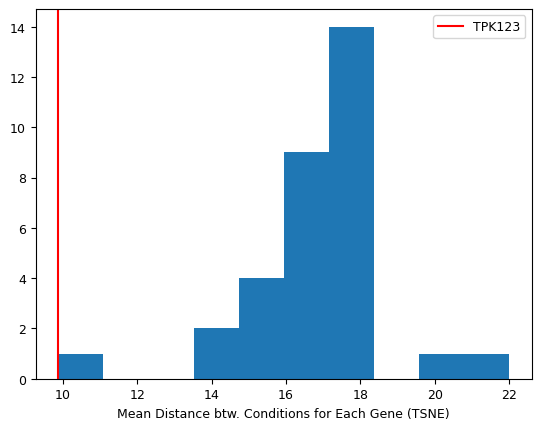

In [81]:
plt.hist(euc_dist)
plt.axvline(TPK123_tnse_mean_euc_dist,c = 'r',label='TPK123')
if method == 'tsne':
    plt.xlabel('Mean Distance btw. Conditions for Each Gene (TSNE)')
elif method == 'pca':
    plt.xlabel('Mean Distance btw. Conditions for Each Gene (PCA)')
if method == 'tsne':
    plt.savefig('figures/fig5f.svg', format='svg', bbox_inches='tight')
elif method == 'pca':
    plt.savefig('figures/figS1b.svg', format='svg', bbox_inches='tight')
plt.legend()

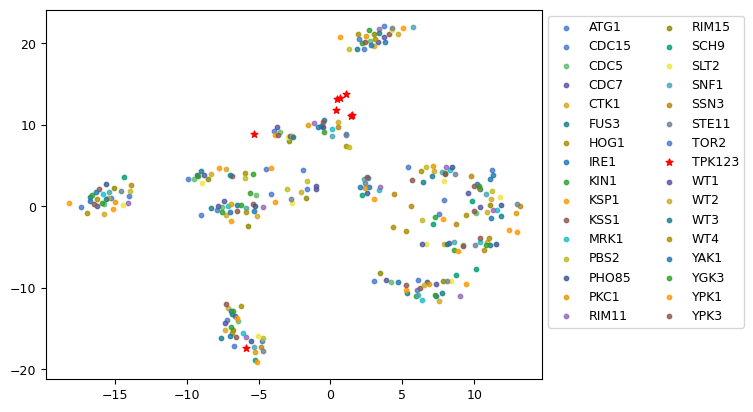

In [82]:
# Create a diverse palette including yellows and oranges, but avoiding true reds
diverse_palette = [
    '#4878D0',  # medium blue
    '#60BD68',  # medium green
    '#5254A3',  # indigo/purple
    '#D0A825',  # gold/amber
    '#177F8C',  # teal
    '#AA8F00',  # dark gold
    '#1F77B4',  # steel blue
    '#2CA02C',  # forest green
    '#FF9900',  # orange (not red-orange)
    '#8C564B',  # chocolate brown
    '#17BECF',  # cyan
    '#BCBD22',  # olive/yellow
    '#3A5894',  # navy
    '#E69900',  # amber
    '#9467BD',  # medium purple
    '#8C8C00',  # olive
    '#009E73',  # seafoam green
    '#F0E442',  # yellow
    '#46A6B4',  # light teal
    '#B8860B',  # dark goldenrod
    '#708090',  # slate gray
]

for i in range(len(strain_list)):
    if strain_list[i] == 'TPK123':
        plt.scatter(np.array(dist_df[strain_masks[strain_list[i]]])[0,:],
                   np.array(dist_df[strain_masks[strain_list[i]]])[1,:],
                   label=strain_list[i], c='r', marker='*', s=25, alpha=1)
    else:
        # Use a color from our custom palette, cycling through them
        color_idx = (i - 1) % len(diverse_palette) if i > 0 else 0
        plt.scatter(np.array(dist_df[strain_masks[strain_list[i]]])[0,:],
                   np.array(dist_df[strain_masks[strain_list[i]]])[1,:],
                   label=strain_list[i], c=diverse_palette[color_idx], s=10, alpha=0.8)

plt.legend(ncol=2, bbox_to_anchor=(1, 1))
if method == 'tnse':
    plt.xlabel('tsne 1')
    plt.ylabel('tsne 2')
elif method == 'pca':
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')

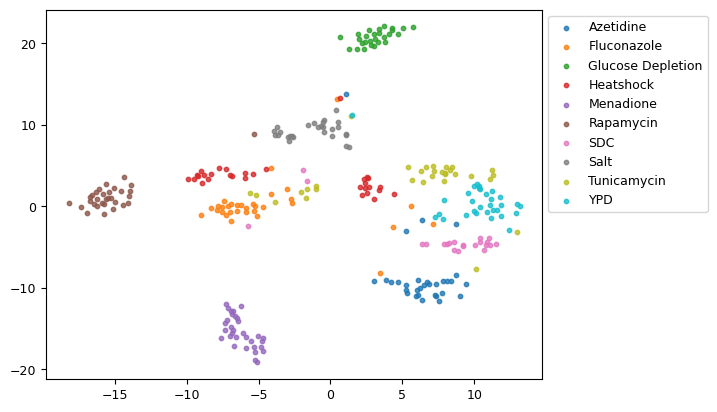

In [83]:
cond_list = list(cond_masks.keys())
for i in range(len(cond_list)):
    plt.scatter(np.array(dist_df[cond_masks[cond_list[i]]])[0,:],np.array(dist_df[cond_masks[cond_list[i]]])[1,:],label=cond_list[i],s=10,alpha = 0.8)
plt.legend(ncol=1,bbox_to_anchor=(1, 1))
if method == 'tnse':
    plt.xlabel('tsne 1')
    plt.ylabel('tsne 2')
elif method == 'pca':
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')

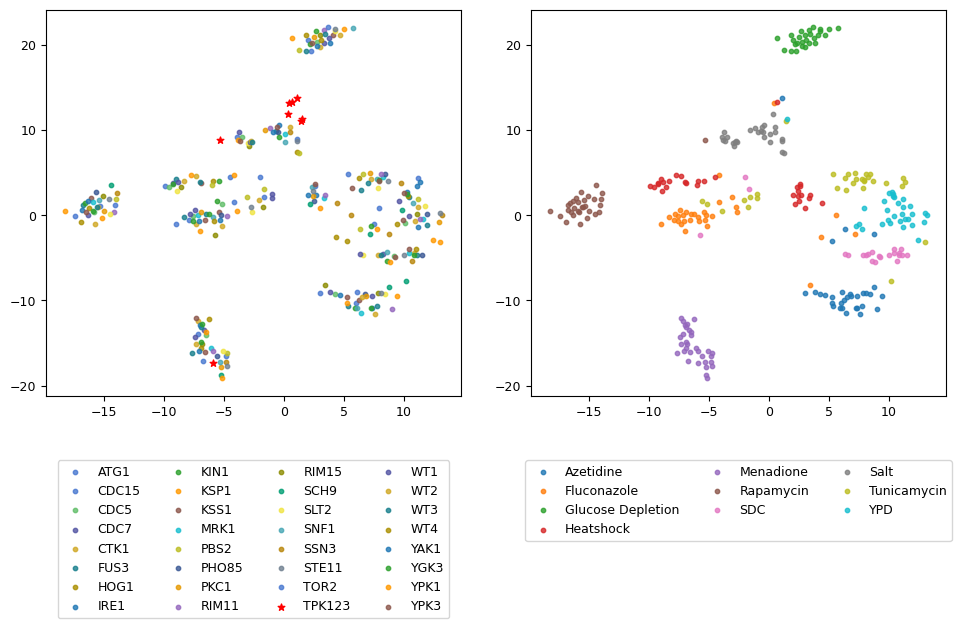

In [84]:
import matplotlib.pyplot as plt
import numpy as np

# Create a square figure with two rectangular subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Your existing diverse palette
diverse_palette = [
    '#4878D0',  # medium blue
    '#60BD68',  # medium green
    '#5254A3',  # indigo/purple
    '#D0A825',  # gold/amber
    '#177F8C',  # teal
    '#AA8F00',  # dark gold
    '#1F77B4',  # steel blue
    '#2CA02C',  # forest green
    '#FF9900',  # orange (not red-orange)
    '#8C564B',  # chocolate brown
    '#17BECF',  # cyan
    '#BCBD22',  # olive/yellow
    '#3A5894',  # navy
    '#E69900',  # amber
    '#9467BD',  # medium purple
    '#8C8C00',  # olive
    '#009E73',  # seafoam green
    '#F0E442',  # yellow
    '#46A6B4',  # light teal
    '#B8860B',  # dark goldenrod
    '#708090',  # slate gray
]

# First subplot - Strains
for i in range(len(strain_list)):
    if strain_list[i] == 'TPK123':
        ax1.scatter(np.array(dist_df[strain_masks[strain_list[i]]])[0,:],
                   np.array(dist_df[strain_masks[strain_list[i]]])[1,:],
                   label=strain_list[i], c='r', marker='*', s=25, alpha=1)
    else:
        # Use a color from our custom palette, cycling through them
        color_idx = (i - 1) % len(diverse_palette) if i > 0 else 0
        ax1.scatter(np.array(dist_df[strain_masks[strain_list[i]]])[0,:],
                   np.array(dist_df[strain_masks[strain_list[i]]])[1,:],
                   label=strain_list[i], c=diverse_palette[color_idx], s=10, alpha=0.8)
ax1.legend(ncol=4, loc='upper center', bbox_to_anchor=(0.5, -0.15))
if method == 'tnse':
    ax1.set_xlabel('tsne 1')
    ax1.set_ylabel('tsne 2')
elif method == 'pca':
    ax1.set_xlabel('pc 1')
    ax1.set_ylabel('pc 2')
# Second subplot - Conditions
cond_list = list(cond_masks.keys())
for i in range(len(cond_list)):
    ax2.scatter(np.array(dist_df[cond_masks[cond_list[i]]])[0,:],
               np.array(dist_df[cond_masks[cond_list[i]]])[1,:],
               label=cond_list[i], s=10, alpha=0.8)
ax2.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.15))
if method == 'tnse':
    ax2.set_xlabel('tsne 1')
    ax2.set_ylabel('tsne 2')
elif method == 'pca':
    ax2.set_xlabel('PC 1')
    ax2.set_ylabel('PC 2')


plt.tight_layout()

plt.subplots_adjust(bottom=0.2)  # Add extra space at the bottom for the legends
if method == 'tsne':
    plt.savefig('figures/fig5d.svg', format='svg', bbox_inches='tight')

plt.show()

In [85]:
dist_df.loc['cond'] = np.zeros(len(dist_df.iloc[0,:]), dtype='U10')
dist_df.loc['strain'] = np.zeros(len(dist_df.iloc[0,:]), dtype='U10')

In [86]:
dist_df

,17d,19d,20d,21d,22d,23d,25d,26d,30d,32d,...,24s,25s,26s,27s,29s,30s,32s,8r,9r,15t
tsne_1,-5.718367,6.64005,8.614289,10.677682,10.028372,-1.9405,6.351449,7.887018,10.847575,10.394019,...,0.372804,-2.83148,-2.693733,-2.633489,-0.892465,-0.417154,-0.543156,-16.755774,-16.568991,7.153104
tsne_2,-2.376414,-4.648109,-4.325012,-5.367931,-4.725493,4.449769,-4.615048,-4.649174,-4.710688,-3.936577,...,11.81228,8.603241,8.637337,8.531125,9.717621,9.14631,10.311067,0.629806,1.396316,4.991624
cond,,,,,,,,,,,...,,,,,,,,,,
strain,,,,,,,,,,,...,,,,,,,,,,


In [87]:
for mask_name, mask in strain_masks.items():
    dist_df.loc['strain', mask] = mask_name

In [88]:
for mask_name, mask in cond_masks.items():
    dist_df.loc['cond', mask] = mask_name

In [89]:
dist_df

,17d,19d,20d,21d,22d,23d,25d,26d,30d,32d,...,24s,25s,26s,27s,29s,30s,32s,8r,9r,15t
tsne_1,-5.718367,6.64005,8.614289,10.677682,10.028372,-1.9405,6.351449,7.887018,10.847575,10.394019,...,0.372804,-2.83148,-2.693733,-2.633489,-0.892465,-0.417154,-0.543156,-16.755774,-16.568991,7.153104
tsne_2,-2.376414,-4.648109,-4.325012,-5.367931,-4.725493,4.449769,-4.615048,-4.649174,-4.710688,-3.936577,...,11.81228,8.603241,8.637337,8.531125,9.717621,9.14631,10.311067,0.629806,1.396316,4.991624
cond,SDC,SDC,SDC,SDC,SDC,SDC,SDC,SDC,SDC,SDC,...,Salt,Salt,Salt,Salt,Salt,Salt,Salt,Rapamycin,Rapamycin,Tunicamycin
strain,RIM15,SLT2,SNF1,SSN3,STE11,TOR2,WT1,WT2,YGK3,YPK3,...,TPK123,WT1,WT2,WT3,YAK1,YGK3,YPK3,IRE1,KIN1,PKC1


In [90]:
dist_mat = np.zeros((len(dist_df.iloc[0,:]),len(dist_df.iloc[0,:])))

In [91]:
for i in range(dist_mat.shape[1]):
    for j in range(dist_mat.shape[1]):
        dist_mat[i,j] = np.sqrt(np.sum((np.array(dist_df.iloc[0:-2,i]) - np.array(dist_df.iloc[0:-2,j]))**2))

In [92]:
avg_cond_dist = np.zeros(len(dist_df.iloc[0,:]))

In [93]:
len(avg_cond_dist)

295

In [94]:
for i in range(len(dist_df.iloc[0,:])):
    for j in range(len(dist_df.iloc[0,:])):
        if dist_df.iloc[-2,i] == dist_df.iloc[-2,j]:
            avg_cond_dist[i] = avg_cond_dist[i] + dist_mat[i,j]
avg_cond_dist = avg_cond_dist/9

In [95]:
avg_gen_dist = np.zeros(len(strain_list))
for i in range(avg_gen_dist.shape[0]):
    for j in range(len(avg_cond_dist)):
        if dist_df.iloc[-1,j] == strain_list[i]:
            avg_gen_dist[i] = avg_gen_dist[i] + avg_cond_dist[j]
avg_gen_dist = avg_gen_dist/10

In [96]:
for i in range(len(strain_list)):
    print(strain_list[i])
    print(avg_gen_dist[i])
    if strain_list[i] == 'TPK123':
        TPK123_cond_mean_euc_dist = avg_gen_dist[i]

ATG1
11.912796607253386
CDC15
10.122000541059682
CDC5
12.967865782022283
CDC7
12.16577529193128
CTK1
11.252393808058295
FUS3
11.27663289837861
HOG1
15.044262741235215
IRE1
10.896228752117665
KIN1
13.054752163276111
KSP1
13.448904684612135
KSS1
10.127425931891478
MRK1
10.253792967861175
PBS2
15.357475002180365
PHO85
10.336175100079185
PKC1
10.029218399634994
RIM11
10.322926146763756
RIM15
17.132763176624326
SCH9
15.640176354182042
SLT2
11.461760504133089
SNF1
10.87318411479571
SSN3
15.989558002206781
STE11
11.878257597737926
TOR2
13.798620665288965
TPK123
31.544878422522935
WT1
11.122173211594822
WT2
11.499895616599341
WT3
10.198425573106439
WT4
3.9004973120934765
YAK1
10.411554031422297
YGK3
10.071438938884038
YPK1
14.669684975961909
YPK3
11.17055155108431


In [97]:
TPK123_cond_mean_euc_dist

31.544878422522935

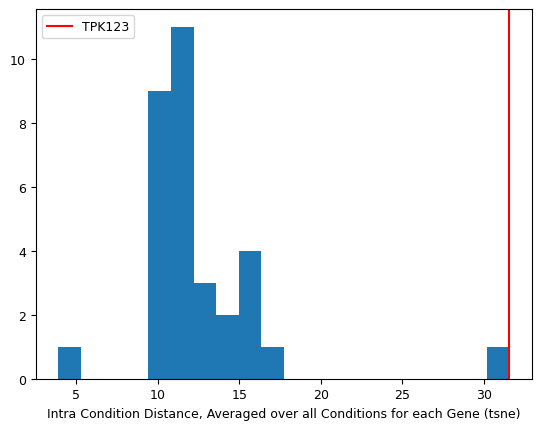

In [98]:
plt.hist(avg_gen_dist,bins = 20)
if method == 'tsne':
    plt.xlabel('Intra Condition Distance, Averaged over all Conditions for each Gene (tsne)')
elif method == 'pca':
    plt.xlabel('Intra Condition Distance, Averaged over all Conditions for each Gene (PCA)')
plt.axvline(TPK123_cond_mean_euc_dist,c='r',label='TPK123')
plt.legend()
if method == 'tsne':
    plt.savefig('figures/fig5e.svg', format='svg', bbox_inches='tight')
elif method == 'pca':
    plt.savefig('figures/figS1c.svg', format='svg', bbox_inches='tight')